In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
from rdkit.Chem.Draw import IPythonConsole #Needed to show molecules
from rdkit import Chem
from rdkit.Chem import PandasTools
from IPython.display import HTML

# Fragment Error Analysis 1 (Lipophilicity-ID)
Date: January 13, 2021
## Objectives
Isolate fragment impact from fragment frequency.  The idea is to minimize the impact of highly frequent fragments
such as `ccc`.

### Approach
1. Split molecules into "easy to predict" and "hard to predict"
    1. Top and bottom quartiles of scaled average error
    2. This might need to be **dataset specific**.  Molecules or fragments that are difficult to predict for one
      property may not be difficult for the next.  These effects will offset in an average error.
      Try logP14k without scaled error in next attempt.

2. Compare and contrast fragments from these groups.
    1. Are the most common (by number of appearances) the same?

3. Remove highly conserved fragments.  Fragments that are present in both in easy and hard to predict molecule sets
 are removed.
    1. This might remove all fragments?
    2. Maybe remove the top `n` most frequent or the top `X%` most frequent

4. Identify which fragments are most popular based on relationship counts and relationship error weights.


5.  Analyze results.

#  Fragment Analysis
Ideally, we would be able to calculate molecule `difficulty` on the fly when running the analysis.   A user may want to know what fragments are difficult for a particular chemical property, such as logP.  In this scenario, the `difficulty` property should only consider logP errors.  But then we have a user-query specific property persisting in the mother graph, which is undesired.  My less than elegant solution is as follows:
1. Remove all `difficulty` weights
2. Make new `difficulty` weights for the chemical property of interest
3. Run Fragment Analysis
4. Remove the `difficulty` weights

## Streamlined Cypher Procedure
Cypher commands can be run in Batch using `;` to separate the commands, but the outputs will be suppressed.  So the command that returns your results should be run by itself.  These first 3 commands can be run together, however. They remove old weights, set the dataset of interest, and create new weights for use with the analysis.  

### Prepare Graph
```cypher
// Delete old weights
MATCH (M:Molecule)-[f:HAS_FRAGMENT]->(F:Fragment)
REMOVE M.difficulty, f.difficulty                      
RETURN M, F, f;

// Set the Dataset you are interested in
:param data => "Lipophilicity-ID.csv"; // must be in separate command from MATCH

// Make new weights for Dataset
MATCH (D:DataSet{data: $data})-[:SPLITS_INTO_TEST]->(T:TestSet)-[p:CONTAINS_PREDICTED_MOLECULE]->(M:Molecule)-[f:HAS_FRAGMENT]->(F:Fragment)
WITH avg(p.average_error) as difficulty, f, M, F
SET M.difficulty = difficulty                      
SET f.difficulty = difficulty
RETURN M, F, f;
```
### Run Fragment Analysis
The command below produces the fragment analysis and returns the number of relationships, the sum of their errors and the average error.

```cypher
// Remove Common Fragments
MATCH (D:DataSet{data: $data})-[c:CONTAINS_MOLECULE]->(M:Molecule)
WITH  percentileCont(M.difficulty, 0.90) as cutoff

MATCH (D:DataSet{data: $data})-[c:CONTAINS_MOLECULE]->(eM:Molecule)-[ef:HAS_FRAGMENT]->(eF:Fragment)
WHERE eM.difficulty < cutoff // easy molecules
WITH eF, count(ef) as efreq, cutoff // gath frags and frequency
ORDER BY efreq DESC LIMIT 1000  //  limit to top n
WITH  collect(eF) as easyFrags, cutoff

MATCH (D:DataSet{data: $data})-[c:CONTAINS_MOLECULE]->(hM:Molecule)-[hf:HAS_FRAGMENT]->(hF:Fragment)
WHERE hM.difficulty > cutoff // hard molecules
WITH hF, count(hf) as hfreq, easyFrags
ORDER BY hfreq DESC LIMIT 1000
WITH collect(hF) as hardFrags, easyFrags

// use APOC to do list intersect & subtraction
WITH apoc.coll.intersection(easyFrags, hardFrags) as overlap, apoc.coll.subtract(hardFrags, easyFrags) as remain 

// Find Molecule-Fragment pairs that have the remaining fragments and are in the dataset
UNWIND remain as rFrags
MATCH (D:DataSet{data: $data})-[c:CONTAINS_MOLECULE]->(M:Molecule)-[f:HAS_FRAGMENT]->(rFrags)
WITH M, rFrags
MATCH (M)-[f:HAS_FRAGMENT]->(rFrags)

// Get Difficulty Stats for Remaining Fragments
WITH rFrags.name as fragment, count(f) as number_of_rel, sum(f.difficulty) as sum_difficulty,sum(f.difficulty)/count(f) as avg_difficulty// , M, rFrags,f 
RETURN fragment, number_of_rel, sum_difficulty, avg_difficulty
ORDER BY number_of_rel DESC, avg_difficulty DESC                                                       
```
### Clean up
***RUN THIS AT THE END to clean up after yourself!***

```cypher
// Delete weights again
MATCH (D:DataSet{data: $data})-[:SPLITS_INTO_TEST]->(T:TestSet)-[p:CONTAINS_PREDICTED_MOLECULE]->(M:Molecule)-[f:HAS_FRAGMENT]->(F:Fragment)
WITH avg(p.average_error) as difficulty, f, M, F
REMOVE M.difficulty = difficulty                      
REMOVE f.difficulty = difficulty
RETURN M, F, f LIMIT 20;
```

## The Fragment Analysis Results
Upon running the fragment analysis, I saved the Cypher results as a CSV. The Cypher query sorts the fragments first by the number of incoming relationships, i.e how many molecules have that fragment and then by the average prediction difficulty.  The results are below.

In [2]:
pd.options.display.float_format = '{:,.3f}'.format
path = 'LipoID/'
frags = pd.read_csv(path + 'Frag_Analysis_lipoID.csv')
frags
print(frags.head(10).to_latex(index=False))

\begin{tabular}{lrrr}
\toprule
      fragment &  number\_of\_rel &  sum\_difficulty &  avg\_difficulty \\
\midrule
     cc<-X>cNC &             68 &          52.305 &           0.769 \\
      ccnc[nH] &             67 &          51.577 &           0.770 \\
      c<=O>nCc &             67 &          49.381 &           0.737 \\
      ccC<=O>C &             65 &   4,125,764.503 &      63,473.300 \\
      CCCC<-O> &             65 &          49.380 &           0.760 \\
 c<-X>cC<=O>NC &             65 &          48.605 &           0.748 \\
     ccCnc<=O> &             65 &          47.445 &           0.730 \\
      cc-c(c)s &             65 &          46.205 &           0.711 \\
        c<-O>c &             64 &          66.091 &           1.033 \\
       ncc[nH] &             64 &          50.588 &           0.790 \\
\bottomrule
\end{tabular}



These results look pretty normal. Next sort by average difficulty as the primary sort key.

In [3]:
frags.sort_values(by="avg_difficulty", ascending=False).head(15)

,fragment,number_of_rel,sum_difficulty,avg_difficulty
176,CC<=O>OC,27,"4,125,750.869","152,805.588"
165,CC<=O>O,30,"4,125,754.296","137,525.143"
139,C<=O>NC(C)C<=O>,37,"4,125,747.645","111,506.693"
128,CC[C@@H](C<=O>)N,39,"4,125,748.824","105,788.431"
114,CCCCC<=O>,41,"4,125,753.673","100,628.138"
106,CCC<-N>,43,"4,125,756.081","95,947.816"
107,CCC<-C(=O)O>,43,"4,125,746.367","95,947.590"
62,c<-N>cC<=O>,54,"4,125,762.618","76,403.011"
48,CC<-N>,57,"4,125,767.508","72,381.886"
12,cccC<=O>C,63,"4,125,762.791","65,488.298"


### Fragment Analysis without any filtering
The below results are for the same data but without the remove of common fragments.


```cypher
// Fragment Analysis for All Mols and Frags
MATCH (D:DataSet{data: $data})-[:SPLITS_INTO_TEST]->(T:TestSet)-[c:CONTAINS_PREDICTED_MOLECULE]->(M:Molecule)-[f:HAS_FRAGMENT]->(F:Fragment)
WHERE EXISTS(f.difficulty)
WITH M, F
MATCH (M)-[f:HAS_FRAGMENT]->(F)

// Get Difficulty Stats for Remaining Fragments
WITH F.name as fragment, count(f) as number_of_rel, sum(f.difficulty) as sum_difficulty,sum(f.difficulty)/count(f) as avg_difficulty// , M, rFrags,f 
RETURN fragment, number_of_rel, sum_difficulty, avg_difficulty
ORDER BY number_of_rel DESC, avg_difficulty DESC

```

In [4]:
frags_all = pd.read_csv(path + 'Frag_Analysis_All_lipoID.csv')
frags_all

,fragment,number_of_rel,sum_difficulty,avg_difficulty
0,cc,17288,"41,269,762.822","2,387.191"
1,ccc,16903,"41,269,402.222","2,441.543"
2,cccc,16256,"41,268,967.161","2,538.691"
3,ccccc,15352,"41,268,301.432","2,688.138"
4,CC,12350,"41,266,039.007","3,341.380"
...,...,...,...,...
20207,CNCNc,1,0.012,0.012
20208,C<-SO2CH3>CN,1,0.010,0.010
20209,CCNCC<-SO2CH3>,1,0.010,0.010
20210,C<-SO2CH3>CNC,1,0.010,0.010


Seems pretty normal.  

In [5]:
frags_all.sort_values(by="avg_difficulty", ascending=False).head(15)

,fragment,number_of_rel,sum_difficulty,avg_difficulty
8661,C<=O>NC(C<-O>)C<=O>,10,"41,257,203.732","4,125,720.373"
8659,C<-C(=O)N>C(C<=O>)N,10,"41,257,203.732","4,125,720.373"
8669,C[C@H](N)C<=O>O,10,"41,257,203.732","4,125,720.373"
8668,C<=O>CCC<=O>O,10,"41,257,203.732","4,125,720.373"
8667,CC<=O>NCC<-C(=O)O>,10,"41,257,203.732","4,125,720.373"
8666,CC<=O>NCC<-C(=O)N>,10,"41,257,203.732","4,125,720.373"
8665,C<=O>CC(C)C<-C(=O)O>,10,"41,257,203.732","4,125,720.373"
8664,C<=O>NC(C<-C(=O)N>)C<=O>,10,"41,257,203.732","4,125,720.373"
8663,C<-N>CCCC<=O>,10,"41,257,203.732","4,125,720.373"
8662,C<=O>NC(C<-C(=O)O>)C<=O>,10,"41,257,203.732","4,125,720.373"


### Finding the Difficult Molecules
The above results are for fragments, but fragments inherit their `difficulty` from the parent molecules.  So I wrote a Cypher query to rank molecules by their `difficulty` (average prediction error). Note, this does not rule out any "easy to predict" molecules.

```cypher
MATCH (D:DataSet{data: $data})-[:CONTAINS_MOLECULE]->(M:Molecule)
WHERE EXISTS (M.difficulty)
WITH M.smiles as SMILES, M.difficulty as Difficulty, id(M) as Node_ID
RETURN DISTINCT SMILES, Difficulty, Node_ID
ORDER BY Difficulty DESC LIMIT 100
```

The results are below:

In [6]:
from rdkit.Chem.Draw import IPythonConsole #Needed to show molecules
from rdkit import Chem
from rdkit.Chem import PandasTools
from IPython.display import HTML;

In [7]:
mols = pd.read_csv(path + 'Molecule_diff_lipoID.csv')
mols.head(10)

,SMILES,Difficulty,Node_ID
0,CCCCCCCCCC(=O)N[C@@H](Cc1c[nH]c2ccccc12)C(=O)N...,"4,125,720.373",11205
1,CC(N)(COP(=O)(O)O)C(=O)O,3.334,9995
2,Cc1oc(CN2CCNCC2)cc1C(=O)NCC12CC3CC(CC(C3)C1)C2,3.242,11514
3,CN(C)c1ccc2nc3ccc(=[N+](C)C)cc-3sc2c1,3.177,10507
4,N#Cc1ccc(-c2csc(Nc3ccc(O)cc3)n2)cc1,3.148,9108
5,NCc1ccc(NC(=O)c2cc(Nc3ncccn3)c3cc(/C(N)=N/O)cc...,3.143,9616
6,COCCCOc1ccnc(C[S+]([O-])c2nc3ccccc3[nH]2)c1C,3.141,11022
7,COCCNCc1ccc(CCNC[C@H](O)c2ccc(O)c3[nH]c(=O)sc2...,3.049,8433
8,COc1ccc(-c2nc3c(NCCCNC(=O)c4ccccc4)c(Br)cnc3[n...,2.944,10397
9,O=C(O)c1ccc2cccc(O)c2n1,2.891,9533


The results show that a single molecule is responsible for the huge fragment `difficulty`.  With the SMILES and Node ID in hand, I can visualize the molecule and find it in the graph to explore its connections. 

In [8]:
PandasTools.AddMoleculeColumnToFrame(mols,'SMILES','Molecule')

,SMILES,Difficulty,Node_ID,Molecule
0,CCCCCCCCCC(=O)N[C@@H](Cc1c[nH]c2ccccc12)C(=O)N[C@@H](CC(N)=O)C(=O)N[C@@H](CC(=O)O)C(=O)N[C@@H]1C(=O)NCC(=O)N[C@@H](CCCN)C(=O)N[C@@H](CC(=O)O)C(=O)N[C@H](C)C(=O)N[C@@H](CC(=O)O)C(=O)NCC(=O)N[C@H](CO)C(=O)N[C@@H]([C@H](C)CC(=O)O)C(=O)N[C@@H](CC(=O)c2ccccc2N)C(=O)O[C@@H]1C,"4,125,720.373",11205,
1,CC(N)(COP(=O)(O)O)C(=O)O,3.334,9995,
2,Cc1oc(CN2CCNCC2)cc1C(=O)NCC12CC3CC(CC(C3)C1)C2,3.242,11514,
3,CN(C)c1ccc2nc3ccc(=[N+](C)C)cc-3sc2c1,3.177,10507,
4,N#Cc1ccc(-c2csc(Nc3ccc(O)cc3)n2)cc1,3.148,9108,
5,NCc1ccc(NC(=O)c2cc(Nc3ncccn3)c3cc(/C(N)=N/O)ccc3c2)cc1,3.143,9616,
6,COCCCOc1ccnc(C[S+]([O-])c2nc3ccccc3[nH]2)c1C,3.141,11022,
7,COCCNCc1ccc(CCNC[C@H](O)c2ccc(O)c3[nH]c(=O)sc23)cc1,3.049,8433,
8,COc1ccc(-c2nc3c(NCCCNC(=O)c4ccccc4)c(Br)cnc3[nH]2)cc1,2.944,10397,
9,O=C(O)c1ccc2cccc(O)c2n1,2.891,9533,

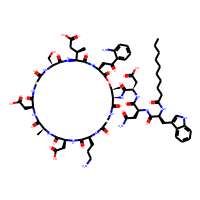
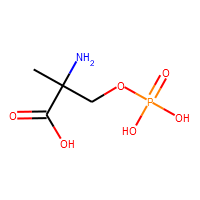
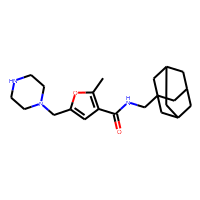
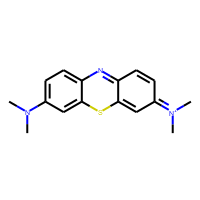
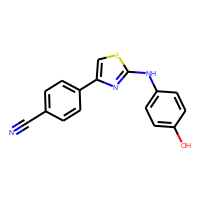
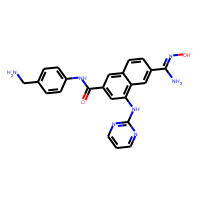
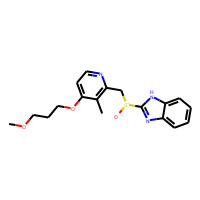
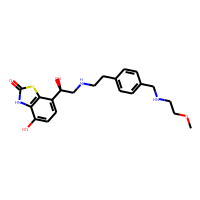
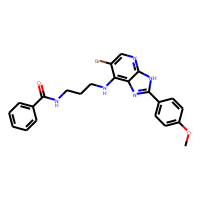
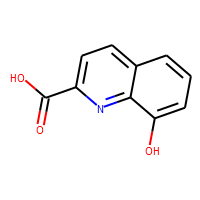

In [9]:
# mols["SMILES"]= mols["SMILES"].str.wrap(15) 

HTML(mols.head(10).to_html())  #work around to broken mole viz

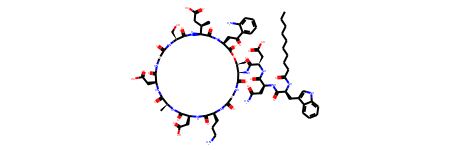

In [10]:
Chem.MolFromSmiles(mols.at[0, "SMILES"])

### Throw out the run-away models 
The large macro-cycle has two models that predict astronomical numbers for it.  This is skewing the results, so we want to run the analysis without those two predictions messing things up.  The below Cypher can replace step 1 of the procedure (preparation).

```cypher
// Delete old weights
MATCH (M:Molecule)-[f:HAS_FRAGMENT]->(F:Fragment)
WHERE EXISTS(M.difficulty) or EXISTS(F.difficulty)
REMOVE M.difficulty, f.difficulty                      
RETURN M, F, f;

:param data => "Lipophilicity-ID.csv";

// Make new weights for LogP
MATCH (D:DataSet{data: $data})-[:SPLITS_INTO_TEST]->(T:TestSet)-[p:CONTAINS_PREDICTED_MOLECULE]->(M:Molecule)-[f:HAS_FRAGMENT]->(F:Fragment)
WHERE p.average_error < 10
WITH avg(p.average_error) as difficulty, f, M, F
SET M.difficulty = difficulty                      
SET f.difficulty = difficulty
RETURN M, F, f;
```

The only difference is that we are only considering predictions that have error less than 10. Keep in mind, this is a log property, so being off by more than 10 is *really bad*.  

#### Filtered Fragments sorted by connections 

In [25]:
frags2 = pd.read_csv(path + 'Frag_Analysis_lipoID2.csv')
print(frags2[['fragment','number_of_rel','avg_difficulty']].head(10).to_latex(index=False))

\begin{tabular}{lrr}
\toprule
      fragment &  number\_of\_rel &  avg\_difficulty \\
\midrule
     cc<-X>cNC &             68 &           0.769 \\
      ccnc[nH] &             67 &           0.770 \\
      c<=O>nCc &             67 &           0.737 \\
      CCCC<-O> &             65 &           0.760 \\
 c<-X>cC<=O>NC &             65 &           0.748 \\
     ccCnc<=O> &             65 &           0.730 \\
      ccC<=O>C &             65 &           0.713 \\
      cc-c(c)s &             65 &           0.711 \\
        c<-O>c &             64 &           1.033 \\
       ncc[nH] &             64 &           0.790 \\
\bottomrule
\end{tabular}



#### Filtered Fragments sorted by average difficulty

In [26]:
frags2.sort_values(by="avg_difficulty", ascending=False).head(15)
print(frags2[['fragment','number_of_rel','avg_difficulty']].sort_values(by="avg_difficulty", ascending=False).head(10).to_latex(index=False))

\begin{tabular}{lrr}
\toprule
                fragment &  number\_of\_rel &  avg\_difficulty \\
\midrule
 ccc(c<-OMe>)S(<=O>)<=O> &             15 &           1.275 \\
       ccN(C)S(<=O>)<=O> &             21 &           1.230 \\
       CCN(c)S(<=O>)<=O> &             16 &           1.225 \\
                CC<=O>OC &             27 &           1.212 \\
                 CC<=O>O &             30 &           1.205 \\
             c<-O>cc(c)c &             21 &           1.205 \\
               cNC<=O>Nc &             16 &           1.159 \\
     c<-OMe>cS(<=O>)<=O> &             20 &           1.131 \\
    cc<-OMe>cS(<=O>)<=O> &             20 &           1.131 \\
    c<-OMe>cS(<=O>)<=O>N &             20 &           1.131 \\
\bottomrule
\end{tabular}



#### All fragments sorted by connections

In [28]:
frags_all2 = pd.read_csv(path + 'Frag_Analysis_All_lipoID2.csv')
frags_all2
print(frags_all2[['fragment','number_of_rel','avg_difficulty']].head(10).to_latex(index=False))

\begin{tabular}{lrr}
\toprule
fragment &  number\_of\_rel &  avg\_difficulty \\
\midrule
      cc &          17288 &           0.728 \\
     ccc &          16903 &           0.723 \\
    cccc &          16256 &           0.725 \\
   ccccc &          15352 &           0.724 \\
      CC &          12350 &           0.717 \\
      CN &          11484 &           0.702 \\
      cn &          10822 &           0.721 \\
     ccC &          10180 &           0.726 \\
     CCN &          10120 &           0.698 \\
     ccn &           9930 &           0.706 \\
\bottomrule
\end{tabular}



#### All fragments sorted by average difficulty

In [29]:
frags_all2.sort_values(by="avg_difficulty", ascending=False).head(15)
print(frags_all2[['fragment','number_of_rel','avg_difficulty']].sort_values(by="avg_difficulty", ascending=False).head(10).to_latex(index=False))

\begin{tabular}{lrr}
\toprule
                             fragment &  number\_of\_rel &  avg\_difficulty \\
\midrule
                  CC(<-C(=O)O>)<-N>CO &              5 &           3.334 \\
 CC(<-C(=O)O>)<-N>COP(<-O>)(<-O>)<=O> &              5 &           3.334 \\
                  COP(<-O>)(<-O>)<=O> &              5 &           3.334 \\
                    CC(<-C(=O)O>)<-N> &              5 &           3.334 \\
  C(<-C(=O)O>)<-N>COP(<-O>)(<-O>)<=O> &              5 &           3.334 \\
                   C(<-C(=O)O>)<-N>CO &              5 &           3.334 \\
                   CC(<-C(=O)O>)<-N>C &              5 &           3.334 \\
               c(<=NCH3>)<=NCH3>ccc-c &              2 &           3.177 \\
                ccc(<=NCH3>)<=NCH3>cc &              2 &           3.177 \\
                cccc(<=NCH3>)<=NCH3>c &              2 &           3.177 \\
\bottomrule
\end{tabular}



#### All molecules sorted by difficulty

In [15]:
mols2 = pd.read_csv(path + 'Molecule_diff_lipoID2.csv')
mols2.head(10)

,SMILES,Difficulty,Node_ID
0,CC(N)(COP(=O)(O)O)C(=O)O,3.334,9995
1,Cc1oc(CN2CCNCC2)cc1C(=O)NCC12CC3CC(CC(C3)C1)C2,3.242,11514
2,CN(C)c1ccc2nc3ccc(=[N+](C)C)cc-3sc2c1,3.177,10507
3,N#Cc1ccc(-c2csc(Nc3ccc(O)cc3)n2)cc1,3.148,9108
4,NCc1ccc(NC(=O)c2cc(Nc3ncccn3)c3cc(/C(N)=N/O)cc...,3.143,9616
5,COCCCOc1ccnc(C[S+]([O-])c2nc3ccccc3[nH]2)c1C,3.141,11022
6,COCCNCc1ccc(CCNC[C@H](O)c2ccc(O)c3[nH]c(=O)sc2...,3.049,8433
7,COc1ccc(-c2nc3c(NCCCNC(=O)c4ccccc4)c(Br)cnc3[n...,2.944,10397
8,O=C(O)c1ccc2cccc(O)c2n1,2.891,9533
9,CC(=O)Nc1ccc2c(c1)c(-c1cc(NC3CC3)n3ncc(C#N)c3n...,2.794,8274


In [16]:
PandasTools.AddMoleculeColumnToFrame(mols2,'SMILES','Molecule')


**Difficult Molecules Visualized**

,SMILES,Difficulty,Node_ID,Molecule
0,CC(N)(COP(=O)(O)O)C(=O)O,3.334,9995,
1,Cc1oc(CN2CCNCC2)cc1C(=O)NCC12CC3CC(CC(C3)C1)C2,3.242,11514,
2,CN(C)c1ccc2nc3ccc(=[N+](C)C)cc-3sc2c1,3.177,10507,
3,N#Cc1ccc(-c2csc(Nc3ccc(O)cc3)n2)cc1,3.148,9108,
4,NCc1ccc(NC(=O)c2cc(Nc3ncccn3)c3cc(/C(N)=N/O)ccc3c2)cc1,3.143,9616,
5,COCCCOc1ccnc(C[S+]([O-])c2nc3ccccc3[nH]2)c1C,3.141,11022,
6,COCCNCc1ccc(CCNC[C@H](O)c2ccc(O)c3[nH]c(=O)sc23)cc1,3.049,8433,
7,COc1ccc(-c2nc3c(NCCCNC(=O)c4ccccc4)c(Br)cnc3[nH]2)cc1,2.944,10397,
8,O=C(O)c1ccc2cccc(O)c2n1,2.891,9533,
9,CC(=O)Nc1ccc2c(c1)c(-c1cc(NC3CC3)n3ncc(C#N)c3n1)cn2CCC(=O)O,2.794,8274,

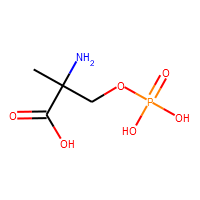
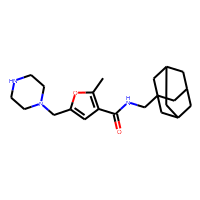
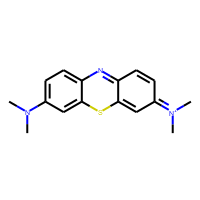
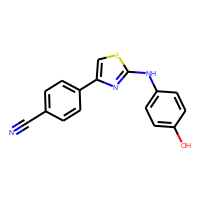
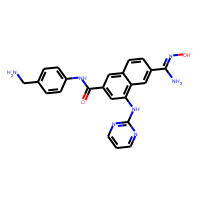
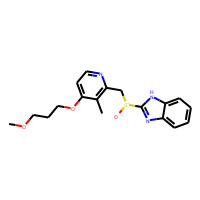
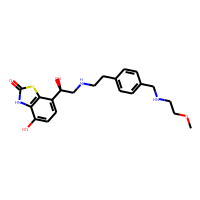
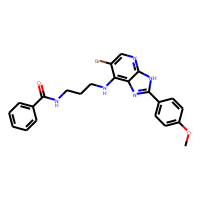
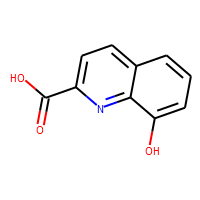
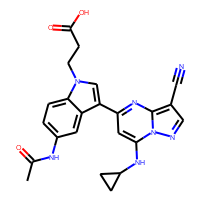

In [17]:
HTML(mols2.head(10).to_html())  #work around to broken mole viz